In [26]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
from sklearn.model_selection import train_test_split

1. naver 질문과 답변 데이터 이해와 전처리(질문열만 사용)

1) 데이터 로드하기

In [28]:
naver = pd.read_csv('E:/더조은/프로젝트/NEW_3/지식인all.csv')
naver.head()

,질문,답변,질문_불용어제거,답변_불용어제거
0,요즘 청년 창업이 붐이지 않습니까 대학 동기들끼리 모여 알찜 알탕 가게를 창업하게...,안녕하세요 대한변리사회 네이버 지식iN 상담변리사 김신연 입니다 네 음식특허의...,요즘 청년 창업 붐 이지 않습니까 대학 동기 끼리 모여 알찜 알탕 가게 창업 하게 ...,안녕하세요 대 한 변리 사회 네이버 지식 iN 상담 변리사 김신 연 입니다 음식 특...
1,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...,안녕하세요 대한변리사회 네이버 지식iN 상담변리사 윤웅채입니다 음식 레시피...,음식 특허 레시피 특허 검색 해보다가 윤웅 채 변리사 님 쓰셨던 글 본적 있습니다 ...,안녕하세요 대 한 변리 사회 네이버 지식 iN 상담 변리사 윤웅 채 입니다 음식 레...
2,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...,0음식 레시피 알려주세요 90 토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 ...,토마토 브로콜리 녹차 당근 마늘 무 이렇게 가지 재료 한가지 라도 쓰는 음식 레시...,0 음식 레시피 알려주세요 90 토마토 브로콜리 녹차 당근 마늘 무 이렇게 5 가지...
3,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...,편의점에서 판매하는 다양한 상품을 활용하여 맛있는 음식을 만드는 방법에 대해 알려드...,편의점 파는 음식 만들수있는 맛있는 음식 레시피 알려주세요 단 라면 류 사용 금지 ...,편의점 판매 하는 다양한 상품 활용 하여 맛있는 음식 만드는 방법 대해 알려 드리겠...
4,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...,양장피 양장피 만드는 법 양장피 만드는 법 송화단 넣어 더욱 있어 보이는 양장...,재료 개 들어간 음식 레시피 알려주세요 기 수행평가 임 진짜 자세하게 정확히 순서...,양장 피 양장 피 만드는 법 양장 피 만드는 법 송화단 넣어 더욱 있어 보이는 양장...


In [29]:
naver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   질문        4861 non-null   object
 1   답변        4853 non-null   object
 2   질문_불용어제거  4861 non-null   object
 3   답변_불용어제거  4849 non-null   object
dtypes: object(4)
memory usage: 152.0+ KB


In [30]:
naver = naver[['질문']]
naver.head()

,질문
0,요즘 청년 창업이 붐이지 않습니까 대학 동기들끼리 모여 알찜 알탕 가게를 창업하게...
1,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...
2,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...
3,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...
4,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...


In [56]:
naver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      4861 non-null   object
dtypes: object(1)
memory usage: 38.1+ KB


In [62]:
# 분류하기
def classify_question(question):

    recipe_pattern = [
        re.compile(r'\b(요리|레시피|만드는 방법|요리법|요리방법)\b', re.IGNORECASE),
        re.compile(r'\b(어떻게 만들지|어떻게 만들어|어떻게 요리해|조리순서|요리순서알려줘)\b', re.IGNORECASE)
    ]
    
    recommendation_pattern = [
        re.compile(r'\b(추천|어떤 것|무엇을 먹을까)\b', re.IGNORECASE),
        re.compile(r'\b(뭐 먹을지|무엇을 먹어|뭘 먹을까)\b', re.IGNORECASE)
    ]

    for pattern in  recipe_pattern:
        if pattern.search(question):
            return 'recipe'
    for pattern in recommendation_pattern:
        if pattern.search(question):
            return 'recommendation'
    return 'other'

In [63]:
recipe_questions = []
recommendation_requests = []
other_questions = []


for index, row in naver.iterrows():
    question = row['질문']
    category = classify_question(question)
    if category == 'recipe':
        recipe_questions.append(question)
    elif category == 'recommendation':
        recommendation_requests.append(question)
    else:
        other_questions.append(question)

In [64]:
len(recipe_questions)

1180

In [65]:
len(recommendation_requests)

212

In [66]:
len(other_questions)

3469

In [67]:
# 재료 및 음식은 0, 아무거나 혹은 추천은 1, 나머지는 기타 2 로 임의로 분류하기
recipe_questions_label =[]
for _ in range(len(recipe_questions)):
    recipe_questions_label.append(0)
len(recipe_questions_label)

1180

In [68]:
recommendation_requests_label =[]
for _ in range(len(recommendation_requests)):
    recommendation_requests_label.append(1)
len(recommendation_requests_label)

212

In [69]:
other_questions_label =[]
for _ in range(len(other_questions)):
    other_questions_label.append(2)
len(other_questions_label)

3469

In [70]:
train_data = pd.DataFrame({'질문': recipe_questions + recommendation_requests + other_questions,
                           'label' : recipe_questions_label + recommendation_requests_label + other_questions_label})

In [75]:
train_data[train_data['label']== 2]

,질문,label
1392,요즘 청년 창업이 붐이지 않습니까 대학 동기들끼리 모여 알찜 알탕 가게를 창업하게...,2
1393,음식특허 레시피특허로 이것저것 검색을 해보다가 윤웅채변리사님이 쓰셨던 글을 본적이...,2
1394,편의점에서 파는 음식으로 만들수있는 맛있는 음식레시피 알려주세요 단 라면류 사용...,2
1395,고양이를 만나라는 게임의 유저인데 도데체 동그라미친 음식의 레시피는 무엇인가요 ...,2
1396,1 단어 5개 이상인 6개의 문장 2 명령문 최소 3문장 3 명사 y로 만들어...,2
...,...,...
4856,버스도 택시도 타지못하는 아들녀석과 1박2일 부산을 다녀오고 싶은데 다행히도 지하철...,2
4857,친구랑 목포로 놀러가려고 하는데 놀게 뭐 있을까료,2
4858,보라카이 3박4일 여행 가려고 하는데요 비행기 숙소는 이미 예약한 상태고 2일차...,2
4859,내일 아빠랑 외식하는데 먹을 음식 좀 추천햐주세요,2


In [76]:
train_data.reset_index(drop=True, inplace= True)

In [77]:
train_data.tail()

,질문,label
4856,버스도 택시도 타지못하는 아들녀석과 1박2일 부산을 다녀오고 싶은데 다행히도 지하철...,2
4857,친구랑 목포로 놀러가려고 하는데 놀게 뭐 있을까료,2
4858,보라카이 3박4일 여행 가려고 하는데요 비행기 숙소는 이미 예약한 상태고 2일차...,2
4859,내일 아빠랑 외식하는데 먹을 음식 좀 추천햐주세요,2
4860,저희 아버지께서 5n세 입니다 요새 말 횟수가 줄어지고 기운이 없어보이는데 가족...,2


In [78]:
train_data.to_csv('./train_data_q.csv', index=False)

,질문,label
0,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...,0
1,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...,0
2,가게 오픈 준비중인데 강릉인가 어떤 시장에서 특허출원번호를 적어놓고 마케팅으로 활용...,0
3,인구수 적은 촌에서 도가니탕 삼계탕 비슷한 요리들만하는 식당을 하고있었는데 젊은층 ...,0
4,음식 레시피가 있는데 이걸로 특허등록을 받아볼까 합니다 근데 레시피의 어떤 부분...,0


In [80]:
naver_q = pd.read_csv('./train_data_q.csv')
naver_q.head()

,질문,label
0,토마토 브로콜리 녹차 당근 마늘 무 이렇게 5가지 재료를 한가지라도 쓰는 음식 레시...,0
1,재료 5개 이상 들어간 음식 레시피 알려주세요 기가 수행평가임 진짜 자세하게 정확히...,0
2,가게 오픈 준비중인데 강릉인가 어떤 시장에서 특허출원번호를 적어놓고 마케팅으로 활용...,0
3,인구수 적은 촌에서 도가니탕 삼계탕 비슷한 요리들만하는 식당을 하고있었는데 젊은층 ...,0
4,음식 레시피가 있는데 이걸로 특허등록을 받아볼까 합니다 근데 레시피의 어떤 부분...,0


In [81]:
# 훈련데이터와 테스트 데이터로 나누기 (총 4861개에서 훈련은 3889개, 테스트는 972개로 임의로 나누기)
# 데이터의 인덱스 섞기
indices = np.random.permutation(len(naver_q))



In [82]:
train_indices = indices[:3888]
train_data = naver_q.iloc[train_indices]

In [83]:
test_indices = indices[3888:]
test_data = naver_q.iloc[test_indices]

In [84]:
# train_dta에 존재하는 질문 갯수 확인
print('훈련용 질문 개수 :', len(train_data))

훈련용 질문 개수 : 3888


In [85]:
train_data.head()

,질문,label
846,고구마 줄기 간단한 요리 하나만 알려주세요 레시피요,0
4547,중국 절강성 특징과 뭐 문화적이든 아니면 음식이든 아무거나 엄청 길게 다양히 알려주...,2
2324,백종원 선생님 유튜브 보고 요리하려고 하는데 그램 수로 해야 하나요 아니면 큰술로 ...,2
2383,생라면 부셔서 스프찍어 먹으려고하는데 라면 추천좀요,2
1016,안녕하세요 학교 실과 수업에서 모둠별로 찐 계란이 들어간 요리를 만들게 된 학생인...,0


In [86]:
print('테스트용 질문 개수: ', len(test_data))

테스트용 질문 개수:  973


In [88]:
test_data.head()

,질문,label
2530,깍두기를 맛있게 담고 싶은데 백종원 수미네반찬 전부 레시피를 보니 설탕이 ...,2
1472,음식레시피 어디에서 보나요ㅠㅠㅠ,2
3154,무청 시래기랑 무우 깔고 만든 가자미조림 같은거 좋아하시는분들 많나요 집밥메뉴로...,2
488,백종원오징어볶음 레시피 알려주세요,0
3981,집에서 먹을수 있는 음식,2


2) 데이터 정제하기

In [89]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['질문'].nunique(), train_data['label'].nunique()

(3741, 3)

In [90]:
# 중복 샘플 제거하기
train_data.drop_duplicates(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\4240426155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=['질문'], inplace=True)


In [91]:
len(train_data)

3741

<Axes: xlabel='label'>

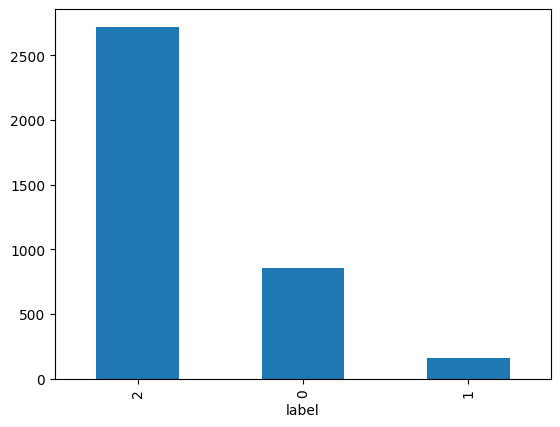

In [92]:
# 분류 레이블 값 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [93]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0    855
1      1    165
2      2   2721


In [94]:
# null값 확인하기
train_data.isnull().sum()

질문       0
label    0
dtype: int64

In [95]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3741 entries, 846 to 1176
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      3741 non-null   object
 1   label   3741 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.7+ KB


In [96]:
# 전처리 _ 특수문자 등 한글만 남기고 제거하기.
# 정규 표현식 사용
train_data['질문'] = train_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\2510707911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'] = train_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


,질문,label
846,고구마 줄기 간단한 요리 하나만 알려주세요 레시피요,0
4547,중국 절강성 특징과 뭐 문화적이든 아니면 음식이든 아무거나 엄청 길게 다양히 알려주...,2
2324,백종원 선생님 유튜브 보고 요리하려고 하는데 그램 수로 해야 하나요 아니면 큰술로 ...,2
2383,생라면 부셔서 스프찍어 먹으려고하는데 라면 추천좀요,2
1016,안녕하세요 학교 실과 수업에서 모둠별로 찐 계란이 들어간 요리를 만들게 된 학생인...,0


In [98]:
# label -> 0: 재료,음식, 1: 추천, 2: 기타
train_data[train_data['label'] == 2]

,질문,label
4547,중국 절강성 특징과 뭐 문화적이든 아니면 음식이든 아무거나 엄청 길게 다양히 알려주...,2
2324,백종원 선생님 유튜브 보고 요리하려고 하는데 그램 수로 해야 하나요 아니면 큰술로 ...,2
2383,생라면 부셔서 스프찍어 먹으려고하는데 라면 추천좀요,2
1938,안주용 오징어 볶음 매운맛 조리법 있나요,2
4018,배고픈데 간단히 먹을거 없낭요,2
...,...,...
4171,알감자 통으로 찐건줄 알았는데 속을 으깨서 한건지 포슬포슬 부드럽더라고요 이건 이...,2
2614,혼남 혼자 사는 남자 입니다 집에서 누구나 쉽고 간단하게 만들어 먹을 수 있는 면...,2
1850,저는 초인데요 점심에 집에서 쉽게 제가 쉽게 만들어 먹을 수 있는 요리는 없나요 ...,2
2248,오랜만에 도시락을 쌀일이 생겨 질문드립니다 백종원님의 쉽고 간편하게 만들수있는 ...,2


In [99]:
# 공백만 있거나 빈값을 가진 행이 있다면 null값으로 변경하고 확인
train_data['질문'] = train_data['질문'].str.replace('^ +', "",regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\1941158316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'] = train_data['질문'].str.replace('^ +', "",regex=True)


In [100]:
train_data['질문'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\3777898010.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['질문'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\3777898010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['질문'].replace('', np.nan, inplace=True)


In [103]:
print(train_data.isnull().sum())

질문       0
label    0
dtype: int64


In [102]:
# null값인 행 삭제하기
train_data.dropna(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\3261527192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(subset=['질문'], inplace=True)


In [104]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3740 entries, 846 to 1176
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      3740 non-null   object
 1   label   3740 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.7+ KB


In [105]:
#  테스트 데이터 전처리
test_data.drop_duplicates(subset=['질문'], inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\1024044446.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset=['질문'], inplace=True)


In [106]:
test_data['질문'] = test_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\2820495892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'] = test_data['질문'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [107]:
test_data['질문'] = test_data['질문'].str.replace('^ +', "", regex= True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\2804453816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'] = test_data['질문'].str.replace('^ +', "", regex= True)


In [108]:
test_data['질문'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\3601569623.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['질문'].replace('', np.nan, inplace=True)
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11448\3601569623.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['질문'].replace('', np.nan, inplace=True)


In [109]:
test_data = test_data.dropna(how= 'any')

In [110]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958 entries, 2530 to 4496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   질문      958 non-null    object
 1   label   958 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 22.5+ KB


3)토큰화

In [111]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [112]:
# Okt를 사용하여 형태소 분석
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [113]:
# train_data 에 형태소 분석기를 사용하여 토큰화, 불용어 제거 후 X_train에 저장하기
# tqdm -> terminal 또는 notebook 자동으로 진행상태를 시각적으로 보여주는 라이브러리
X_train=[]
for sentence in tqdm(train_data['질문']):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 3740/3740 [00:28<00:00, 129.49it/s]


In [114]:
X_train[:3]

[['고구마', '줄기', '간단하다', '요리', '하나', '만', '알다', '레시피', '요'],
 ['중국',
  '절강성',
  '특징',
  '뭐',
  '문화',
  '적',
  '이든',
  '아니다',
  '음식',
  '이든',
  '아무',
  '거나',
  '엄청',
  '길다',
  '다양하다',
  '알다',
  'ㅠㅠ'],
 ['백종원',
  '선생님',
  '유튜브',
  '보고',
  '요리',
  '그램',
  '수로',
  '하나요',
  '아니다',
  '크다',
  '술',
  '로',
  '하나요',
  '그램',
  '수',
  '랑',
  '크다',
  '술',
  '이랑',
  '양',
  '다른',
  '것',
  '같다',
  '욤',
  'ㅜㅜㅜ']]

In [115]:
X_test = []
for sentence in tqdm(test_data['질문']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 958/958 [00:07<00:00, 128.56it/s]


4) 정수인코딩

In [116]:
# 훈련데이터에 대해서 단어집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [117]:
# 단어집합 생성 및 각 단어에 고유 index 부여 확인
tokenizer.word_index

{'있다': 1,
 '먹다': 2,
 '을': 3,
 '요리': 4,
 '로': 5,
 '레시피': 6,
 '알다': 7,
 '요': 8,
 '에서': 9,
 '만들다': 10,
 '음식': 11,
 '되다': 12,
 '제': 13,
 '같다': 14,
 '없다': 15,
 '추천': 16,
 '좋다': 17,
 '이다': 18,
 '안': 19,
 '집': 20,
 '해주다': 21,
 '수': 22,
 '보다': 23,
 '것': 24,
 '저': 25,
 '간단하다': 26,
 '다': 27,
 '어떻다': 28,
 '만': 29,
 '때': 30,
 '싶다': 31,
 '메뉴': 32,
 '고': 33,
 '아니다': 34,
 '맛있다': 35,
 '나': 36,
 '좋아하다': 37,
 '넣다': 38,
 '인데': 39,
 '들다': 40,
 '너무': 41,
 '집밥': 42,
 '않다': 43,
 '부탁드리다': 44,
 '많이': 45,
 '분': 46,
 '정도': 47,
 '중': 48,
 '거': 49,
 '뭐': 50,
 '못': 51,
 'ㅠㅠ': 52,
 '가다': 53,
 '이나': 54,
 '그렇다': 55,
 '밥': 56,
 '하고': 57,
 '저녁': 58,
 '자다': 59,
 '재료': 60,
 '랑': 61,
 '생각': 62,
 '면': 63,
 '많다': 64,
 '그': 65,
 '맛': 66,
 '적': 67,
 '더': 68,
 '괜찮다': 69,
 '모르다': 70,
 '안녕하다': 71,
 '곳': 72,
 '그냥': 73,
 '이랑': 74,
 '그리고': 75,
 '궁금하다': 76,
 '개': 77,
 '게': 78,
 '시간': 79,
 '살': 80,
 '계란': 81,
 '나오다': 82,
 '해보다': 83,
 '자취': 84,
 '해': 85,
 '김치': 86,
 '방법': 87,
 '이렇다': 88,
 '걸': 89,
 '서': 90,
 '일': 91,
 '해먹': 92,
 '전': 9

In [118]:
total_cnt = len(tokenizer.word_index)

In [119]:
#  단어 집합의 최대 크기 제한
#  0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9240


In [120]:
#  텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [121]:
X_train[:3]

[[454, 864, 26, 4, 167, 29, 7, 6, 8],
 [611,
  5332,
  1453,
  50,
  961,
  67,
  1175,
  34,
  11,
  1175,
  434,
  542,
  277,
  1971,
  493,
  7,
  52],
 [130,
  543,
  200,
  146,
  4,
  1547,
  2416,
  265,
  34,
  194,
  405,
  5,
  265,
  1547,
  22,
  61,
  194,
  405,
  74,
  336,
  111,
  24,
  14,
  1087,
  1372]]

In [122]:
len(X_train)

3740

In [123]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [124]:
len(y_train)

3740

6) 패딩

질문의 최대 길이 :  1102
질문의 평균 길이 :  35.80294117647059


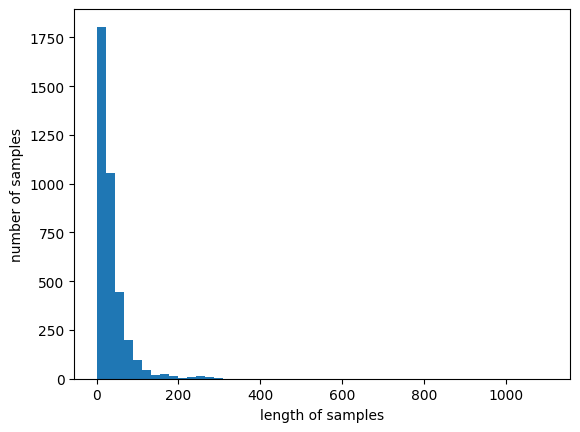

In [125]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
print('질문의 최대 길이 : ', max(len(question) for question in X_train))
print('질문의 평균 길이 : ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(question) for question in X_train], bins =50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [126]:

# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    count =0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count / len(nested_list))*100))

In [137]:
#  max_len을 160 이하인 샘플의 비율 확인(250 이하 : 99.19, 150이하 :97.67)
max_len =160
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 160 이하인 샘플의 비율 : 98.04812834224599


In [138]:
# 모든 샘플의 길이를 160로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

2. LSTM으로 질문 분류하기

#다중 클래스 분류 => 출력층에 로지스틱 회귀 사용.

#활성화함수 : 소프트 맥스 함수, 손실함수 : 크로스 엔트로피함수

#하이퍼파라미터인 배치크기 : 64, 에포크 :100

#EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미

#ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만모델을 저장

#validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인

#검증데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은지 확인하기 위한 용도로 사용됨.

In [142]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from keras.utils import to_categorical

In [143]:
# 실제 레이블을 원-핫 인코딩
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [144]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = X_train.shape[1]))
model.add(LSTM(hidden_units))
model.add(Dense(3, activation='softmax'))  # 출력층의 뉴런 수를 클래스 수로 설정

# 모델 저장 디렉토리 확인 및 생성
model_dir = './model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 조기종료 및 모델 체크포인트 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(filepath=os.path.join(model_dir, 'best_model.h5'),  monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 모델 컴파일
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  # categorical_crossentropy 사용


# 모델 학습
history = model.fit(X_train, y_train_onehot, epochs=100, callbacks=[es, mc], batch_size=64, validation_data= (X_test, y_test_onehot))

# 디버깅: 체크포인트 파일 확인
if os.path.exists(os.path.join(model_dir, 'best_model.h5')):
    print("모델이 성공적으로 저장되었습니다.")
else:
    print("모델이 저장되지 않았습니다. 경로를 확인하세요.")

Epoch 1/100
58/59 [============================>.] - ETA: 0s - loss: 0.7212 - accuracy: 0.7193
Epoch 1: val_accuracy improved from -inf to 0.73278, saving model to ./model\best_model.h5
59/59 [==============================] - 9s 85ms/step - loss: 0.7211 - accuracy: 0.7190 - val_loss: 0.6150 - val_accuracy: 0.7328
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.7767
Epoch 2: val_accuracy improved from 0.73278 to 0.77766, saving model to ./model\best_model.h5
59/59 [==============================] - 4s 71ms/step - loss: 0.5273 - accuracy: 0.7767 - val_loss: 0.5132 - val_accuracy: 0.7777
Epoch 3/100
58/59 [============================>.] - ETA: 0s - loss: 0.4106 - accuracy: 0.8244
Epoch 3: val_accuracy improved from 0.77766 to 0.79854, saving model to ./model\best_model.h5
59/59 [==============================] - 4s 70ms/step - loss: 0.4120 - accuracy: 0.8238 - val_loss: 0.5085 - val_accuracy: 0.7985
Epoch 4/100
58/59 [===========================

In [145]:
# 조기조# 훈련 종료 후 테스트데이터에 대해서 정확도를 측정. 훈련과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5' 로드
loaded_model  = load_model(os.path.join(model_dir, 'best_model.h5'))
# 테스트 정확도 평가
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot)
print("\n 테스트 정확도: %.4f" % test_accuracy)

30/30 [==============================] - 1s 18ms/step - loss: 0.5085 - accuracy: 0.7985

 테스트 정확도: 0.7985


In [146]:
# 토크나이저 파일로 저장 후 로드
with open ('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizer.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

3. 리뷰 예측해보기

In [61]:
# 임의의 리뷰에 대해서 예측하는 함수 만들기
# 기본적으로 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용.
# model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함

In [147]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
    new_sentence = okt.morphs(new_sentence, stem = True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어제거

    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences (encoded, maxlen = max_len)  # 패딩

    predictions = loaded_model.predict(pad_new)  # 3개의 클래스에 대한 확률 예측

    #  예측 결과 출력
    class_names = ['재료 및 음식', '추천', '기타']
    predicted_class = np.argmax(predictions, axis=1)[0]

    # 각 클래스에 대한 확률 출력
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]*100:.2f}% 확률")

    print(f"\n예측된 클래스: {class_names[predicted_class]}")


In [148]:
sentiment_predict('김치찌개 어케 만들까')

1/1 [==============================] - 0s 344ms/step
재료 및 음식: 2.02% 확률
추천: 1.44% 확률
기타: 96.54% 확률

예측된 클래스: 기타


In [149]:
sentiment_predict('감자로 만들수 있는 요리')

1/1 [==============================] - 0s 20ms/step
재료 및 음식: 35.57% 확률
추천: 3.61% 확률
기타: 60.81% 확률

예측된 클래스: 기타


In [150]:
sentiment_predict('소고기')

1/1 [==============================] - 0s 20ms/step
재료 및 음식: 2.54% 확률
추천: 2.57% 확률
기타: 94.89% 확률

예측된 클래스: 기타


In [151]:
sentiment_predict('레시피 추천해줘')

1/1 [==============================] - 0s 21ms/step
재료 및 음식: 43.81% 확률
추천: 27.33% 확률
기타: 28.86% 확률

예측된 클래스: 재료 및 음식


In [154]:
sentiment_predict('된장찌개 만드는법 ')

1/1 [==============================] - 0s 21ms/step
재료 및 음식: 1.20% 확률
추천: 0.82% 확률
기타: 97.98% 확률

예측된 클래스: 기타


In [155]:
sentiment_predict('요리순서 알려줘 ')

1/1 [==============================] - 0s 26ms/step
재료 및 음식: 25.51% 확률
추천: 1.70% 확률
기타: 72.78% 확률

예측된 클래스: 기타
